# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Wednesday, March 15, 2023 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). **Make sure you explain your decisions whenever necessary.** 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel. 
For this problem, you will use [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

1. 
Looking at the problem and dataset, my initial thoughts are that there are going to broadly be two types of cancellations: predictable and un-predictable. A predictable cancellation is one that the data in the dataset could potentially help predict. For example, if the customer is travelling alone, booked shortly before the arrival date, and is only staying a few nights it may be predictable that they cancel. This person could be travelling for business and have plans change often and as such cancel hotels fairly routinely as their travel plans change. On the other hand, if the customer is travelling with children or a large group, booked far in advance, and has made several special requests for their room they might be less likely to cancel as this is probably a vacation or larger trip that was planned well in advance, which often isn't cancelled once booked. However, the data will never be able to help "un-predictable" cancellations as these are caused by factors completely irrelevant to the booking itself. For example, even though a family may have booked a vacation many months in advance, they may still have to cancel last-minute because of a health emergency or something similar.  As such, it seems like there will always be a limit to how accurate our model can be because it will not be able to predict these external factors.

In [2]:
df = pd.read_csv("./res_cancel.csv")
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0


<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2)
print(train_df.shape, test_df.shape)

(14509, 18) (3628, 18)


<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14509 entries, 5556 to 3040
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          14509 non-null  int64  
 1   no_of_children                        14509 non-null  int64  
 2   no_of_weekend_nights                  14509 non-null  int64  
 3   no_of_week_nights                     14509 non-null  int64  
 4   type_of_meal_plan                     14509 non-null  int64  
 5   required_car_parking_space            14509 non-null  int64  
 6   room_type_reserved                    14509 non-null  int64  
 7   lead_time                             14509 non-null  int64  
 8   arrival_year                          14509 non-null  int64  
 9   arrival_month                         14509 non-null  int64  
 10  arrival_date                          14509 non-null  int64  
 11  market_segmen

Looking at the above summary information, we can see that there are no missing entries therefore we will not have to impute any features. Additionally, all of the datatypes are either integer or float but looking at the description of some classes (such as type_of_meal_plan), it looks like some of these integer features actually represent categorical data.

In [5]:
train_df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000
mean,1.847956,0.107106,0.812392,2.203598,0.319388,0.032394,0.337997,85.557585,2017.821008,7.427528,15.701358,0.809498,0.024743,0.022607,0.150252,103.589309,0.618237,0.328555
std,0.514914,0.410736,0.872777,1.418996,0.629876,0.177049,0.778044,86.555647,0.383359,3.075368,8.790586,0.644560,0.155347,0.373379,1.726440,35.522538,0.786851,0.469704
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.300000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,58.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,127.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,120.550000,1.000000,1.000000
max,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


In [6]:
cancel = train_df.query("booking_status == 1")
not_cancel = train_df.query("booking_status == 0")

cancel.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
9164,2,0,0,1,1,0,0,109,2018,10,11,1,0,0,0,108.00,0,1
12889,1,0,2,1,0,0,0,116,2018,2,28,1,0,0,0,61.00,0,1
14718,2,0,0,2,0,0,0,211,2018,5,20,1,0,0,0,100.00,0,1
14034,2,0,1,2,1,0,0,178,2018,7,22,1,0,0,0,88.50,0,1
3320,2,0,1,0,0,0,0,185,2017,7,6,1,0,0,0,66.13,0,1


In [7]:
perc_cancel = cancel.shape[0] / train_df.shape[0] * 100
perc_cancel


32.855469019229446

We can see that 32.6% of the total reservations in the train data set cancelled. This statistic tells us that there is a moderate class imbalance between our two target classes and this problem could be considered a spotting problem (albeit with less class imbalance than other examples).

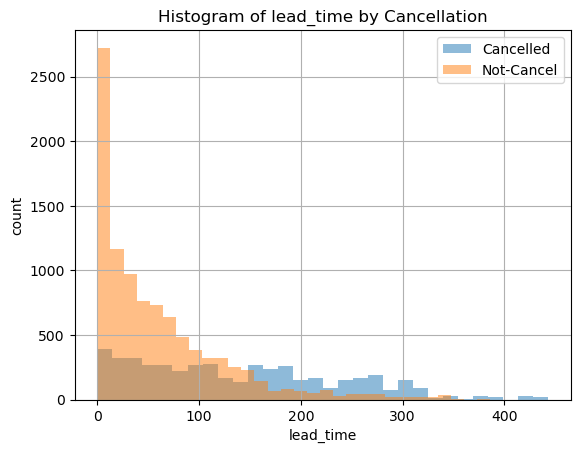

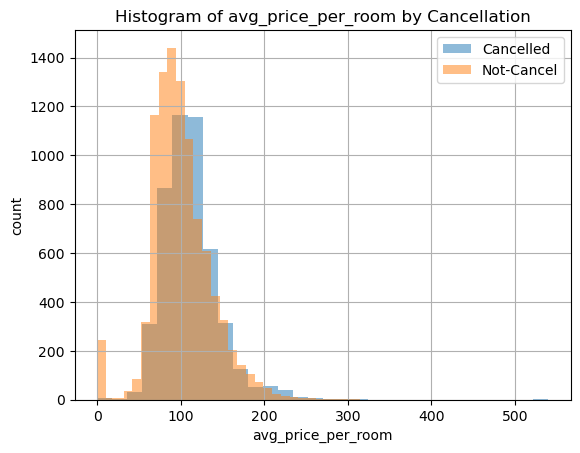

In [8]:
numeric_feats = ["lead_time", "avg_price_per_room"]
num_bins = 30

#Taken from HW3 implementation
for col in numeric_feats:
    axes = cancel[[col]].hist(bins = num_bins, alpha = 0.5, label="Cancelled")[0][0]
    axes.hist(not_cancel[[col]], bins = num_bins, alpha = 0.5, label="Not-Cancel")

    plt.legend(loc = "upper right")
    plt.title("Histogram of " + col + " by Cancellation")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

Looking at the above histograms of numeric features we can see that lead_time will most likely be a useful feature as there are many more non-cancellations for low lead times (~ < 150), but more cancellations than non-cancellations for longer lead times (~ > 150). The average room price histogram shows that the distributions are fairly similar, but there are fewer cancellations for rooms less than $100 and slightly more cancellations above $100.

In [9]:
categorical_feats = ["no_of_adults","no_of_children", "no_of_weekend_nights", "no_of_week_nights", "type_of_meal_plan", "required_car_parking_space", "room_type_reserved",
"arrival_year", "arrival_month", "arrival_date", "market_segment_type", "repeated_guest", "no_of_special_requests", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled"]

for feat in categorical_feats:
    print("Unique values in ", feat, " are: ", np.sort(train_df[feat].unique()))


Unique values in  no_of_adults  are:  [0 1 2 3 4]
Unique values in  no_of_children  are:  [0 1 2 3 9]
Unique values in  no_of_weekend_nights  are:  [0 1 2 3 4 5 6 7]
Unique values in  no_of_week_nights  are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Unique values in  type_of_meal_plan  are:  [0 1 2 3]
Unique values in  required_car_parking_space  are:  [0 1]
Unique values in  room_type_reserved  are:  [0 1 2 3 4 5 6]
Unique values in  arrival_year  are:  [2017 2018]
Unique values in  arrival_month  are:  [ 1  2  3  4  5  6  7  8  9 10 11 12]
Unique values in  arrival_date  are:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Unique values in  market_segment_type  are:  [0 1 2 3 4]
Unique values in  repeated_guest  are:  [0 1]
Unique values in  no_of_special_requests  are:  [0 1 2 3 4 5]
Unique values in  no_of_previous_cancellations  are:  [ 0  1  2  3  4  5  6 11 13]
Unique values in  no_of_previous_bookings_not_canceled 

The majority of our features have integer data types, but some of these features are categorical or ordinal. Looking at the unique values within each feature can help us determine which category the data falls into. For example, room_type_reserved has an integer datatype but each integer represents a different room type as defined by INN Hotels so this data is actually categorical. Some of the integer features which take a small, finite set of values could also be considered ordinal. For example, no_of_adults only takes value from 0 to 4 and there is a clear ordered relation between consecutive values so we could treat this feature as ordinal instead of numeric.

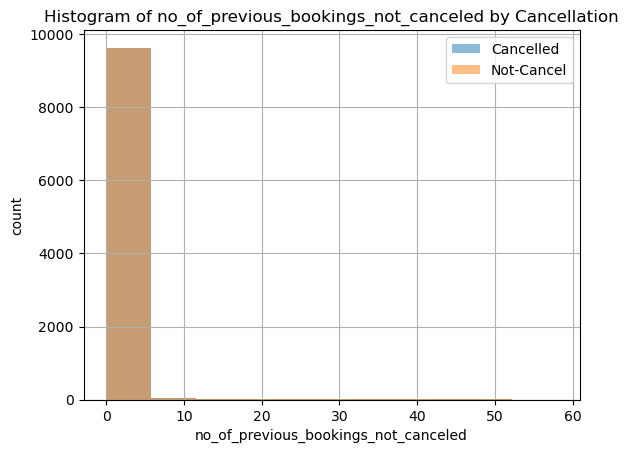

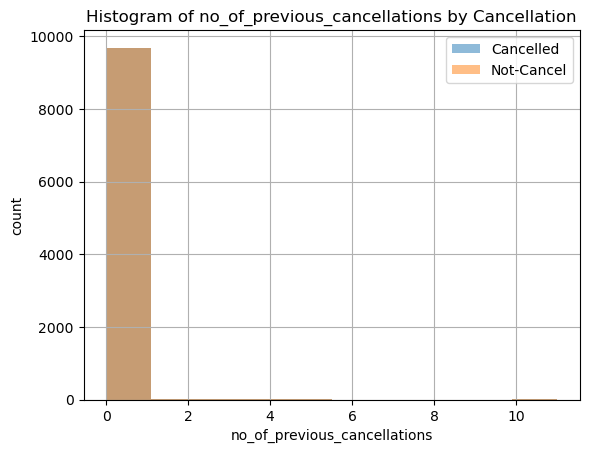

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
9164,2,0,0,1,1,0,0,109,2018,10,11,1,0,0,0,108.00,0,1
12889,1,0,2,1,0,0,0,116,2018,2,28,1,0,0,0,61.00,0,1
14718,2,0,0,2,0,0,0,211,2018,5,20,1,0,0,0,100.00,0,1
14034,2,0,1,2,1,0,0,178,2018,7,22,1,0,0,0,88.50,0,1
3320,2,0,1,0,0,0,0,185,2017,7,6,1,0,0,0,66.13,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15819,2,0,1,1,1,0,0,151,2018,7,11,0,0,0,0,63.75,1,1
6443,1,0,0,3,0,0,2,206,2018,9,8,1,0,0,0,126.90,1,1
7913,2,0,4,10,0,0,1,147,2018,8,3,1,0,0,0,118.88,1,1
13627,2,0,3,6,1,0,0,314,2018,12,26,1,0,0,0,68.66,0,1


In [10]:
previous_cat = ["no_of_previous_bookings_not_canceled", "no_of_previous_cancellations"]

num_bins = 10

for col in previous_cat:
    
    axes = not_cancel[[col]].hist(bins = num_bins, alpha = 0.5, label="Cancelled")[0][0]
    axes.hist(not_cancel[[col]], bins = num_bins, alpha = 0.5, label="Not-Cancel")

    plt.legend(loc = "upper right")
    plt.title("Histogram of " + col + " by Cancellation")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

cancel

In [11]:
print("Percent repeat guest:", train_df.query("repeated_guest==1").shape[0] / train_df.shape[0] * 100)


Percent repeat guest: 2.474326280239851


Looking at the histograms of previous bookings cancelled versus not cancelled, we see that the vast majority of customers have not either cancelled or completed a previous reservation. Checking the repeated guests feature, we can see that only 2.5% of guests are repeat customers. Therefore it makes sense that there wouldn't be many examples where previous bookings were cancelled or not-cancelled. It could be useful to drop these features as they generally don't add much information, but they could be very useful in the few cases where they are not zero. 

## Initial Observations

From the exploratory data analysis, it is clear that there are many potential ways to categorize and process the data. For many of the features you could argue that they should considered numerical, ordinal, or categorical. For example, number of adults could be considered as simple numerical data, ordinal data since it is discrete and there is a clear relationship between each value (difference between 2 and 1 is one person), or even categorical if you don't think the relationship between different numbers of adults matters. There is also some ambiguity with the data in its current form. The type of meal plan or room type feature could be ordinal but it's impossible to conclude that without knowing more about the hotel's systems.  The number of special requests also is hard to interpret because not all special requests are the same and reducing them all to a count loses some specificity. 

Overall, it seems like it will be important to try different methods of pre-processing in order to ensure that the most accurate representation of the given data is found.

## Assessment Metrics

Since the class imbalance is not extreme, accuracy will still be a good indicator of model performance. However, we think precision will be the most important metric to optimize. If the model predicts that a customer is likely to cancel their reservation, the hotel will likely try to re-book the room in preparation for a cancellation. If this prediction was a false positive and the customer does not cancel, the hotel will have a double-booked room which will be costly from both a customer satisfaction and economic standpoint. The customer won't be happy about not getting their desired room and the hotle will likely have to compensate the customer for the inconvenience.

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

Numeric features: lead time, average room price, number previous cancellations, number previous bookings not cancelled
* Transformations: Scaling
* Notes: lead time, previous cancellations, and previous bookings all take integer values but can take a wide range of values so we decided to treat them as numeric and scale  

Categorical features: type of meal plan, room type reserved, market segment type, arrival year, arrival month, arrival date
* Transformations: One Hot Encoding

Ordinal features: number adults, number children, number of weekend nights, number of week nights, number special requests
* Transformations: None (Data is already in an ordinal form)
* Notes: Chose ordinal for these feature because there is generally limited values that appear in data and there is a clear relationship between consecutive numbers within the data

Binary features: repeated guest, required parking space
* Transformations: None (Data already in binary form)

In [12]:
numeric_feats = ["lead_time", "avg_price_per_room", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled"]
categorical_feats = ["type_of_meal_plan", "room_type_reserved", "market_segment_type", "arrival_year", "arrival_month", "arrival_date"]
pass_through = ["repeated_guest", "required_car_parking_space", "no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_week_nights", "no_of_special_requests"]
target = ["booking_status"]

In [13]:
X_train = train_df.drop(columns=target)
print(X_train.shape)
X_train.head()

(14509, 17)


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
5556,2,0,2,2,1,0,0,35,2018,2,19,1,0,0,0,84.35,1
9164,2,0,0,1,1,0,0,109,2018,10,11,1,0,0,0,108.00,0
12889,1,0,2,1,0,0,0,116,2018,2,28,1,0,0,0,61.00,0
2742,2,0,0,1,0,0,0,23,2017,9,4,1,0,0,0,105.00,0
2723,1,0,0,3,0,0,0,71,2018,6,14,0,0,0,0,120.00,0


In [14]:
X_test = test_df.drop(columns=target)
y_train = train_df[target]
y_test = test_df[target]
y_train.head()

,booking_status
5556,0
9164,1
12889,1
2742,0
2723,0


In [15]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(drop="if_binary", handle_unknown="ignore"),  categorical_feats),
    ("passthrough", pass_through)
)

In [16]:
#Code for creating dataframe from transformed X modified from HW3 Implementation
X_train_trans = preprocessor.fit_transform(X_train)
print(X_train_trans.shape)

column_names = (numeric_feats + preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist() + pass_through)
print(len(column_names))
column_names[:10]

(14509, 71)
71


['lead_time',
 'avg_price_per_room',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'type_of_meal_plan_0',
 'type_of_meal_plan_1',
 'type_of_meal_plan_2',
 'type_of_meal_plan_3',
 'room_type_reserved_0',
 'room_type_reserved_1']

In [17]:
X_train_trans_df = pd.DataFrame(X_train_trans.toarray(), columns=column_names)
X_train_trans_df.head()

,lead_time,avg_price_per_room,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,room_type_reserved_0,room_type_reserved_1,...,arrival_date_29,arrival_date_30,arrival_date_31,repeated_guest,required_car_parking_space,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,no_of_special_requests
0,-0.584125,-0.541627,-0.060548,-0.087033,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0
1,0.270846,0.124170,-0.060548,-0.087033,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
2,0.351721,-1.198979,-0.060548,-0.087033,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0
3,-0.722769,0.039714,-0.060548,-0.087033,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
4,-0.168193,0.461996,-0.060548,-0.087033,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0


<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [18]:
#From lecture 3
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.4f (+/- %0.4f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [19]:
results = {}
#Including f1 and recall just for reference even though they are not our key metrics
scoring_metrics = ["accuracy","precision", "recall", "f1" ]

In [20]:
dummy_pipe = make_pipeline(preprocessor, DummyClassifier(strategy="most_frequent"))

results["Dummy Classifier"] = mean_std_cross_val_scores(dummy_pipe, X_train, y_train, cv=10, scoring= scoring_metrics, return_train_score=True)
pd.DataFrame(results)

/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/graysonk546/miniconda3/envs/

,Dummy Classifier
fit_time,0.0206 (+/- 0.0028)
score_time,0.0085 (+/- 0.0019)
test_accuracy,0.6714 (+/- 0.0003)
train_accuracy,0.6714 (+/- 0.0000)
test_precision,0.0000 (+/- 0.0000)
train_precision,0.0000 (+/- 0.0000)
test_recall,0.0000 (+/- 0.0000)
train_recall,0.0000 (+/- 0.0000)
test_f1,0.0000 (+/- 0.0000)
train_f1,0.0000 (+/- 0.0000)


Running $10$ fold cross validation on the dummy classifier yielded average test and validation score results of $0.673$.

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [21]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

results["Default LogReg"] = mean_std_cross_val_scores(lr_pipe, X_train, y_train.values.ravel(),scoring=scoring_metrics, return_train_score=True)
pd.DataFrame(results)

/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Dummy Classifier,Default LogReg
fit_time,0.0206 (+/- 0.0028),0.1810 (+/- 0.0075)
score_time,0.0085 (+/- 0.0019),0.0114 (+/- 0.0068)
test_accuracy,0.6714 (+/- 0.0003),0.8047 (+/- 0.0053)
train_accuracy,0.6714 (+/- 0.0000),0.8076 (+/- 0.0025)
test_precision,0.0000 (+/- 0.0000),0.7344 (+/- 0.0142)
train_precision,0.0000 (+/- 0.0000),0.7403 (+/- 0.0054)
test_recall,0.0000 (+/- 0.0000),0.6360 (+/- 0.0061)
train_recall,0.0000 (+/- 0.0000),0.6384 (+/- 0.0028)
test_f1,0.0000 (+/- 0.0000),0.6816 (+/- 0.0063)
train_f1,0.0000 (+/- 0.0000),0.6856 (+/- 0.0035)


Using the default hyper parameter C, the mean and standard deviation of the 10 fold cross validation scores are $\mu_{val} = 0.806$, $\sigma_{val} = 0.00874$. These are surprisingly good results for a first attempt, so it is important to be diligent in verifying whether any over/under-fitting has occurred. 

A typical sign of under-fitting is similar, low test and validation score values. The average test score $\mu_{test} = 0.8086$ and the average validation score presented above are nearly identical. However, they are both high enough that we can fairly confidently rule out the presence of under-fitting phenomena. Further, we can say that this first attempt model is doing a good job of generalizing to unseen data and has suitable complexity for the problem at hand.

Referencing these baseline linear model results, we can perform hyper-parameter optimization/class-weight optimization to zero-in on a best linear model configuration. Since it is most important for our model to be precise in it's prediction of cancellations (so that the hotel can confidently take steps to account for the cancellation), we should choose "precision" as the scoring metric to be maximized. We also want to maintain a similar accuracy score of ~0.80.

In [22]:
from scipy.stats import uniform

param_dist = {
    "logisticregression__C": uniform(0.01,10), #1e4
    "logisticregression__class_weight": [None, {0:1, 1:3}, "balanced"],
}

random_search = RandomizedSearchCV(
    lr_pipe, param_dist, scoring="precision", n_iter=100, verbose=1, n_jobs=-1, random_state=123
)

random_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  war

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['lead_time',
                                                                                'avg_price_per_room',
                                                                                'no_of_previous_cancellations',
                                                                                'no_of_previous_bookings_not_canceled']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore'),
                                                                               ['type_of_meal_plan',
                                                                                'room_type_reserv...
                                                                                'no_of_week_nights',
                                                                                'no_of_special_requests'])])),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0db771f0d0>,
                                        'logisticregression__class_weight': [None,
                                                                             {0: 1,
                                                                              1: 3},
                                                                             'balanced']},
                   random_state=123, scoring='precision', verbose=1)

In [23]:
print("best score: {s}".format(s=random_search.best_score_))
print("best C and class_weight: {c}".format(c=random_search.best_params_))

best score: 0.7357503585614825
best C and class_weight: {'logisticregression__C': 0.2855138499186016, 'logisticregression__class_weight': None}


In [24]:
lr_pipe_best = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, C=random_search.best_params_["logisticregression__C"], 
                                                              class_weight=random_search.best_params_["logisticregression__class_weight"]))
results["Best LogReg"] = mean_std_cross_val_scores(lr_pipe_best, X_train, y_train.values.ravel(), scoring=scoring_metrics, return_train_score=True)
pd.DataFrame(results)

/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Dummy Classifier,Default LogReg,Best LogReg
fit_time,0.0206 (+/- 0.0028),0.1810 (+/- 0.0075),0.2280 (+/- 0.0378)
score_time,0.0085 (+/- 0.0019),0.0114 (+/- 0.0068),0.0157 (+/- 0.0019)
test_accuracy,0.6714 (+/- 0.0003),0.8047 (+/- 0.0053),0.8052 (+/- 0.0049)
train_accuracy,0.6714 (+/- 0.0000),0.8076 (+/- 0.0025),0.8081 (+/- 0.0030)
test_precision,0.0000 (+/- 0.0000),0.7344 (+/- 0.0142),0.7358 (+/- 0.0128)
train_precision,0.0000 (+/- 0.0000),0.7403 (+/- 0.0054),0.7423 (+/- 0.0062)
test_recall,0.0000 (+/- 0.0000),0.6360 (+/- 0.0061),0.6354 (+/- 0.0073)
train_recall,0.0000 (+/- 0.0000),0.6384 (+/- 0.0028),0.6373 (+/- 0.0042)
test_f1,0.0000 (+/- 0.0000),0.6816 (+/- 0.0063),0.6818 (+/- 0.0063)
train_f1,0.0000 (+/- 0.0000),0.6856 (+/- 0.0035),0.6858 (+/- 0.0047)


Comparing original linear model to model with optimized hyper-parameter and class weight.

After performing hyper-parameter optimization using randomized search, it was determined that the best performing hyper-parameter value was $C = 0.2855$ and the best performing class weight was `None`. Using these optimized parameters yielded slight improvements in the average validation accuracy, and significant improvements in the average precision. The best average accuracy is 0.8062, the best average precision is 0.7367, and the standard deviation of validation accuracy scores is $\sigma_{acc} = 0.00862$.

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

### SVM Model

In [25]:
svm_pipe = make_pipeline(preprocessor, SVC())
results["Default SVM"] = mean_std_cross_val_scores(svm_pipe, X_train, y_train.values.ravel(), scoring=scoring_metrics,return_train_score=True)
pd.DataFrame(results)

/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Dummy Classifier,Default LogReg,Best LogReg,Default SVM
fit_time,0.0206 (+/- 0.0028),0.1810 (+/- 0.0075),0.2280 (+/- 0.0378),4.1523 (+/- 0.2475)
score_time,0.0085 (+/- 0.0019),0.0114 (+/- 0.0068),0.0157 (+/- 0.0019),0.7507 (+/- 0.0146)
test_accuracy,0.6714 (+/- 0.0003),0.8047 (+/- 0.0053),0.8052 (+/- 0.0049),0.8398 (+/- 0.0054)
train_accuracy,0.6714 (+/- 0.0000),0.8076 (+/- 0.0025),0.8081 (+/- 0.0030),0.8525 (+/- 0.0029)
test_precision,0.0000 (+/- 0.0000),0.7344 (+/- 0.0142),0.7358 (+/- 0.0128),0.8039 (+/- 0.0155)
train_precision,0.0000 (+/- 0.0000),0.7403 (+/- 0.0054),0.7423 (+/- 0.0062),0.8246 (+/- 0.0037)
test_recall,0.0000 (+/- 0.0000),0.6360 (+/- 0.0061),0.6354 (+/- 0.0073),0.6780 (+/- 0.0161)
train_recall,0.0000 (+/- 0.0000),0.6384 (+/- 0.0028),0.6373 (+/- 0.0042),0.6998 (+/- 0.0071)
test_f1,0.0000 (+/- 0.0000),0.6816 (+/- 0.0063),0.6818 (+/- 0.0063),0.7354 (+/- 0.0093)
train_f1,0.0000 (+/- 0.0000),0.6856 (+/- 0.0035),0.6858 (+/- 0.0047),0.7571 (+/- 0.0055)


The SVM model achieves test and validation accuracy scores of 0.8547 and 0.8412 respectively. These scores are higher than what the linear model was able to achieve. The average precision scores achieved by the SVM are also higher than the linear model at 0.82 and 0.80 for train and test respectively.

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())
results["Default kNN"] = mean_std_cross_val_scores(knn_pipe, X_train, y_train.values.ravel(), scoring=scoring_metrics,return_train_score=True)
pd.DataFrame(results)

/home/graysonk546/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Dummy Classifier,Default LogReg,Best LogReg,Default SVM,Default kNN
fit_time,0.0206 (+/- 0.0028),0.1810 (+/- 0.0075),0.2280 (+/- 0.0378),4.1523 (+/- 0.2475),0.0186 (+/- 0.0012)
score_time,0.0085 (+/- 0.0019),0.0114 (+/- 0.0068),0.0157 (+/- 0.0019),0.7507 (+/- 0.0146),1.2427 (+/- 0.0511)
test_accuracy,0.6714 (+/- 0.0003),0.8047 (+/- 0.0053),0.8052 (+/- 0.0049),0.8398 (+/- 0.0054),0.8276 (+/- 0.0078)
train_accuracy,0.6714 (+/- 0.0000),0.8076 (+/- 0.0025),0.8081 (+/- 0.0030),0.8525 (+/- 0.0029),0.8841 (+/- 0.0021)
test_precision,0.0000 (+/- 0.0000),0.7344 (+/- 0.0142),0.7358 (+/- 0.0128),0.8039 (+/- 0.0155),0.7566 (+/- 0.0135)
train_precision,0.0000 (+/- 0.0000),0.7403 (+/- 0.0054),0.7423 (+/- 0.0062),0.8246 (+/- 0.0037),0.8502 (+/- 0.0045)
test_recall,0.0000 (+/- 0.0000),0.6360 (+/- 0.0061),0.6354 (+/- 0.0073),0.6780 (+/- 0.0161),0.7009 (+/- 0.0164)
train_recall,0.0000 (+/- 0.0000),0.6384 (+/- 0.0028),0.6373 (+/- 0.0042),0.6998 (+/- 0.0071),0.7856 (+/- 0.0073)
test_f1,0.0000 (+/- 0.0000),0.6816 (+/- 0.0063),0.6818 (+/- 0.0063),0.7354 (+/- 0.0093),0.7276 (+/- 0.0131)
train_f1,0.0000 (+/- 0.0000),0.6856 (+/- 0.0035),0.6858 (+/- 0.0047),0.7571 (+/- 0.0055),0.8166 (+/- 0.0039)


In [27]:
from catboost import CatBoostClassifier

pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, random_state=123)
)

In [28]:
results["CatBoost"] = mean_std_cross_val_scores(pipe_catboost, X_train, y_train, scoring=scoring_metrics, cv=10, return_train_score=True)
pd.DataFrame(results)

,Dummy Classifier,Default LogReg,Best LogReg,Default SVM,Default kNN,CatBoost
fit_time,0.0206 (+/- 0.0028),0.1810 (+/- 0.0075),0.2280 (+/- 0.0378),4.1523 (+/- 0.2475),0.0186 (+/- 0.0012),3.9851 (+/- 0.2972)
score_time,0.0085 (+/- 0.0019),0.0114 (+/- 0.0068),0.0157 (+/- 0.0019),0.7507 (+/- 0.0146),1.2427 (+/- 0.0511),0.0187 (+/- 0.0040)
test_accuracy,0.6714 (+/- 0.0003),0.8047 (+/- 0.0053),0.8052 (+/- 0.0049),0.8398 (+/- 0.0054),0.8276 (+/- 0.0078),0.8802 (+/- 0.0096)
train_accuracy,0.6714 (+/- 0.0000),0.8076 (+/- 0.0025),0.8081 (+/- 0.0030),0.8525 (+/- 0.0029),0.8841 (+/- 0.0021),0.9148 (+/- 0.0014)
test_precision,0.0000 (+/- 0.0000),0.7344 (+/- 0.0142),0.7358 (+/- 0.0128),0.8039 (+/- 0.0155),0.7566 (+/- 0.0135),0.8545 (+/- 0.0219)
train_precision,0.0000 (+/- 0.0000),0.7403 (+/- 0.0054),0.7423 (+/- 0.0062),0.8246 (+/- 0.0037),0.8502 (+/- 0.0045),0.9054 (+/- 0.0021)
test_recall,0.0000 (+/- 0.0000),0.6360 (+/- 0.0061),0.6354 (+/- 0.0073),0.6780 (+/- 0.0161),0.7009 (+/- 0.0164),0.7665 (+/- 0.0244)
train_recall,0.0000 (+/- 0.0000),0.6384 (+/- 0.0028),0.6373 (+/- 0.0042),0.6998 (+/- 0.0071),0.7856 (+/- 0.0073),0.8270 (+/- 0.0034)
test_f1,0.0000 (+/- 0.0000),0.6816 (+/- 0.0063),0.6818 (+/- 0.0063),0.7354 (+/- 0.0093),0.7276 (+/- 0.0131),0.8078 (+/- 0.0160)
train_f1,0.0000 (+/- 0.0000),0.6856 (+/- 0.0035),0.6858 (+/- 0.0047),0.7571 (+/- 0.0055),0.8166 (+/- 0.0039),0.8644 (+/- 0.0024)


## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

SVM: gamma, C
KNN: n_neighbours, C
CatBoost: n_estimators, learning_rate

From part 8 we can see that the CatBoostClassifier performed best based on accuracy, precision, recall, and f1 scores. So we will tune the hyperparameters of this model. From documentation we know by default `n_estimators = 1000`, and the `learning_rate` is automatically assigned a value based on iterations. But we can pass our own values to tune these hyperparameters. In the code below, I have selected values above and below the default for `n_estimators`.

In [ ]:
# param_grid_svc = {
#     "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
#     "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
# }
# param_grid_knn = {
#     "kneighborsclassifier__n_neighbors": np.arange(1, 50, 5),
#     "kneighborsclassifier__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
# }
# param_grid_cat = {
#     "catboostclassifier__n_estimators": [500,1000,2000,3000],
#     "catboostclassifier__learning_rate": np.logspace(-1,-0.4,5,endpoint=False),
# }

# param_grids = [param_grid_svc,param_grid_knn,param_grid_cat]
# pipelines = [svm_pipe,knn_pipe,pipe_catboost]

In [ ]:
# results = []
# for i,pipe in enumerate(pipelines):
#     param_grid = param_grids[i]
#     # random_search = RandomizedSearchCV(
#     #     pipe, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=5, random_state=123
#     # )
#     # random_search.fit(X_train, y_train)
#     # print(param_grid)
#     grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True)
#     grid_search.fit(X_train, y_train)
#     results.append(grid_search)

In [ ]:
param_grid_cat = {
    "catboostclassifier__n_estimators": [500,1000,2000,3000],
    "catboostclassifier__learning_rate": np.logspace(-1,-0.4,5,endpoint=False),
}

As we can see in the heatmap of our gridsearch below...

In [ ]:
grid_search = GridSearchCV(pipe_catboost, param_grid_cat, cv=5, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)

#adapted from lecture 8
results = pd.DataFrame(grid_search.cv_results_)

scores = np.array(results.mean_test_score).reshape(param_grid_cat["catboostclassifier__n_estimators"],3)
scores
import seaborn

# plot the mean cross-validation scores
seaborn.heatmap(
    scores,
    xticklabels=param_grid_cat["logisticregression__class_weight"],
    yticklabels=param_grid_cat["logisticregression__C"],
    cmap="viridis",
)

In [ ]:
random_search = RandomizedSearchCV(
        pipe_catboost, param_distributions=param_grid_cat, n_jobs=-1, n_iter=10, cv=5, random_state=123
    )
random_search.fit(X_train, y_train)

In [ ]:
random_search.best_score_

In [ ]:
n_estimators = random_search.best_params_['catboostclassifier__n_estimators']
learning_rate = random_search.best_params_['catboostclassifier__learning_rate']
random_search.best_params_

From these results we can see the optimal results for `n_estimators` is around `1000~2000`, suggesting that the model is overfitted for more `n_estimators`. And we found or optimal `learning_rate` to be around `0.1~0.2`.

In [ ]:
pd.DataFrame(random_search.cv_results_)

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [ ]:
#adapted from lecture 11

import shap


<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 